In [2]:
import torch
import torch
import torchvision.transforms as T
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
from torch import tensor
IMAGE_SIZE = 128
CENTER_SIZE = 64
BATCH_SIZE = 1500

In [34]:
import math
def display_image(img):
        with torch.no_grad():
                img = img.permute((1, 2, 0))
                plt.imshow(img.cpu().numpy())
                plt.show()

def display_images(imgs, images_per_row=2, title=None):
        with torch.no_grad():
                rows = math.ceil(len(imgs) / images_per_row)
                fig = plt.figure(figsize=(images_per_row*2, rows*2))
                if title:
                        fig.suptitle(title, fontsize=10)
                for i, img in enumerate(imgs):
                        plt.subplot(rows, images_per_row, i+1)
                        plt.axis('off')
                        plt.tight_layout()
                        img = img.permute((1, 2, 0))
                        plt.imshow(img.cpu().numpy())
                plt.show()

def get_center_of_image(img, size=64):
        return T.CenterCrop((size, size))(img)

def get_img_without_center(img, size=64):
        left = (IMAGE_SIZE - CENTER_SIZE) // 2
        right = (IMAGE_SIZE - CENTER_SIZE) // 2 + CENTER_SIZE
        if(len(img.shape) == 3):
                img[ :, left:right, left:right ] = 0
        elif(len(img.shape) == 4):
                img[:, :, left:right, left:right ] = 0
        else:
                raise RuntimeError("Wrong shape to get_img_without_center!")
                
        return img

class CenterImageRemoval(object):
    def __init__(self, image_size, center_size):
        self.image_size = image_size
        self.center_size = center_size
        
    def __call__(self, img):
        left = (self.image_size - self.center_size) // 2
        right = (self.image_size - self.center_size) // 2 + self.center_size

        if(len(img.shape) == 3):
                assert img.shape[1] == img.shape[2] == self.image_size
                img[ :, left:right, left:right ] = 0
        elif(len(img.shape) == 4):
                assert img.shape[2] == img.shape[3] == self.image_size
                img[:, :, left:right, left:right ] = 0

        return img

class AddImageCenter(object):
    def __init__(self, image_size, center_size):
        self.image_size = image_size
        self.center_size = center_size
        
    def __call__(self, img, center):
        assert center.shape[1] == center.shape[2] == self.center_size

        left = (self.image_size - self.center_size) // 2
        right = (self.image_size - self.center_size) // 2 + self.center_size

        if(len(img.shape) == 3):
                assert img.shape[1] == img.shape[2] == self.image_size
                img[ :, left:right, left:right ] = center
        elif(len(img.shape) == 4):
                assert img.shape[2] == img.shape[3] == self.image_size
                img[:, :, left:right, left:right ] = center
        return img

class JointRandomResizeCrop(object):
    def __init__(self, size: int, minimum_scale, maximum_scale):
        """
        params:
            size (int) : size of the center crop
        """
        self.size = size
        self.min_scale = minimum_scale
        self.max_scale = maximum_scale
        
    def __call__(self, img, target):
        scale = (self.max_scale - self.min_scale)*random.random() + self.min_scale
        _, height, width = img.shape
        new_h, new_w = int(height*scale), int(width*scale)

        target = target.reshape((1, height, width))
        resized_img = T.functional.resize(img,  [new_h, new_w])
        resized_target = T.functional.resize(target, [new_h, new_w])
        crop_size = min(self.size, new_h, new_w)
        top = random.randint(0, new_h - crop_size)
        left = random.randint(0, new_w - crop_size)
        resized_img = T.functional.crop(resized_img, top, left, crop_size, crop_size)
        resized_target = T.functional.crop(resized_target, top, left, crop_size, crop_size)

        resized_img = T.functional.resize(resized_img, size=(self.size, self.size))
        resized_target = T.functional.resize(resized_target, size=(self.size, self.size))
        resized_target = resized_target.reshape((self.size, self.size))

        return (resized_img, resized_target)
    
def save_model(encoder, decoder, epoch, optimizer, path):
	state = {
    'epoch': epoch,
    'encoder': encoder.state_dict(),
    'decoder': decoder.state_dict(),
    'optimizer': optimizer.state_dict(),
	}
	torch.save(state, path)


def load_model(encoder, decoder, optimizer, path):
	state = torch.load(path)
	encoder.load_state_dict(state["encoder"])
	decoder.load_state_dict(state["decoder"])
	optimizer.load_state_dict(state["optimizer"])
	return state["epoch"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_tranforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.RandomHorizontalFlip(p=0.5),
    T.ConvertImageDtype(torch.float32),
])

val_tranforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
])

# extra transformation not applied to ground truth images
non_gt_extra_transforms = T.Compose([
    CenterImageRemoval(IMAGE_SIZE, CENTER_SIZE),
])

sanity_transforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.CenterCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
])
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from IPython.display import clear_output

class CustomDataSet(Dataset):
    def __init__(self, root_dir, classes, transform=None, non_gt_extra_transforms=None, training_split=0.8, is_train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.non_gt_extra_transforms = non_gt_extra_transforms

        dirs = np.array(sorted(os.listdir(root_dir)))[classes]
        # print(dirs.shape)
        # train_split = int(dirs.shape[0]*training_split)
        # dirs = dirs[0:train_split]
        # print(dirs.shape)

        self.images = []
        self.cache = {}

        self.is_train = is_train
        for i, dir in enumerate(dirs):
            imgs = sorted(os.listdir(os.path.join(self.root_dir, dir)))
            train_split = int(len(imgs)*training_split)
            if is_train:
                imgs = imgs[0:train_split]
            else:
                imgs = imgs[train_split:]
            for img in imgs:
                self.images.append((os.path.join(self.root_dir, dir, img), classes[i]))
    

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name, class_label = self.images[idx]
        image = None

        if img_name not in self.cache:
            self.cache[img_name] = Image.open(img_name).convert('RGB')
        image = self.cache[img_name]


        if self.transform:
            transformed_image = self.transform(image)
        else:
            transformed_image = None

        gt_image = torch.clone(transformed_image)

        if non_gt_extra_transforms:
            transformed_image = non_gt_extra_transforms(transformed_image)

        return transformed_image, gt_image, class_label


DATASET_PATH = '/pub2/imagenet/ILSVRC/Data/CLS-LOC/train'
# Due to the way the dataset is strucutred, I can't use the offical validation images provided
# Therefore, I'm splitting the provided training_split from the dataset, 90% for training, and 10% for validation

train_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=train_tranforms, 
                                      non_gt_extra_transforms=non_gt_extra_transforms,
                                      classes=classes,
                                      is_train=True,
                                      training_split=0.9
                                      )

validation_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=val_tranforms, 
                                      non_gt_extra_transforms=non_gt_extra_transforms,
                                      classes=classes,
                                      is_train=False
                                      )

# Like the training dataset but only has 1 image
sanity_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=sanity_transforms, 
                                      non_gt_extra_transforms=non_gt_extra_transforms,
                                      classes=classes,
                                      is_train=True,
                                      training_split=0.9
                                      )
sanity_dataset = torch.utils.data.Subset(sanity_dataset, [1])


In [36]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
sanity_loader = DataLoader(sanity_dataset, batch_size=1, shuffle=True)

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [12]:
data = torch.rand((100, 40000))
data = data.numpy()

In [86]:
def get_pca(data):
	data = data.numpy()
	pca = PCA(n_components=2)
	data_2d = pca.fit_transform(data)
	return data_2d



In [ ]:
import torchvision.models as models
resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
resnet.eval()

In [109]:
img_batch, img_batch_gt, image_batch_classes = next(iter(val_loader))

In [43]:
img_batch.shape

torch.Size([520, 3, 128, 128])

In [115]:
class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()
        self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

    def forward(self, inp):
        inp = self.resnet.conv1(inp)
        inp = self.resnet.bn1(inp)
        inp = self.resnet.relu(inp)
        inp = self.resnet.maxpool(inp)
        inp = self.resnet.layer1(inp)
        inp = self.resnet.layer2(inp)
        inp = self.resnet.layer3(inp)
        inp = self.resnet.layer4(inp)
        inp = self.resnet.avgpool(inp)
        inp = inp.reshape((-1, 2048))
        # print("fully encoded shape is", inp.shape)
        return inp

In [116]:
resnet_encoder = ResNetEncoder()


In [122]:
print(img_batch_gt.shape)

torch.Size([520, 3, 128, 128])


In [131]:
tennis_images = image_batch_classes == 852
tiling_images = image_batch_classes == 858

In [119]:
print(tennis_images.shape)
print(tiling.shape)

torch.Size([260, 3, 128, 128])
torch.Size([260, 3, 128, 128])


In [126]:
resnet_out = resnet_encoder(img_batch_gt).detach()

In [127]:
resnet_pca = get_pca(resnet_out)

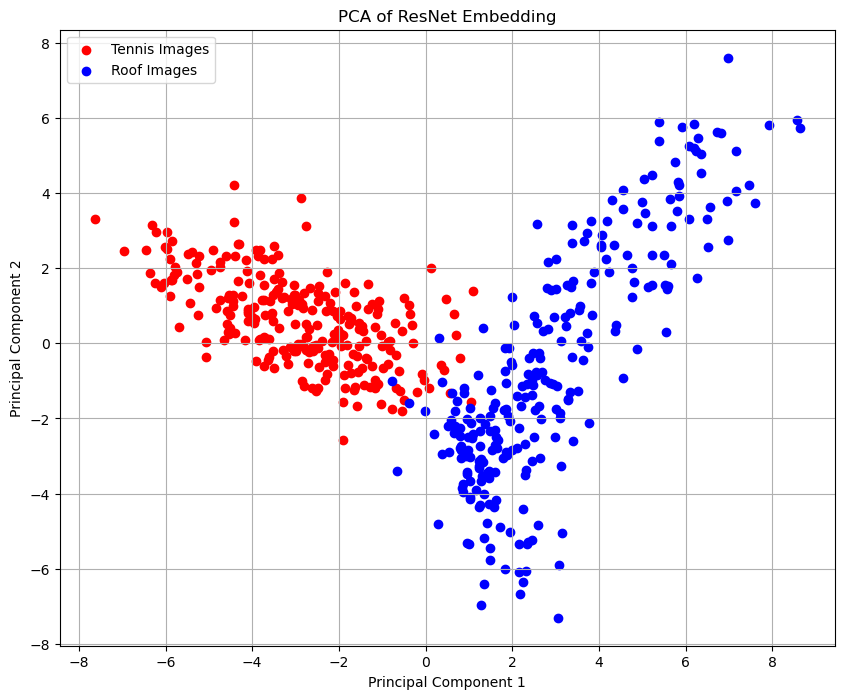

In [142]:

plt.figure(figsize=(10, 8))
plt.scatter(resnet_pca[tennis_images, 0], resnet_pca[tennis_images, 1], color="red", label="Tennis Images")
plt.scatter(resnet_pca[tiling_images, 0], resnet_pca[tiling_images, 1], color="blue", label="Roof Images")
plt.legend()
plt.title("PCA of ResNet Embedding")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()